In [52]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import PIL
from matplotlib.pyplot import imshow
%matplotlib inline
import numpy as np

In [3]:
export_path = './saved_models/1580978860'
model = tf.keras.models.load_model(export_path)

In [29]:
image_string = tf.io.read_file('./data/HEK293/HEK293 40x (1).jpg')
image_decoded = tf.image.decode_jpeg(image_string)
image_resized = tf.image.resize(image_decoded, (224, 224))
image_reshaped = np.expand_dims(image_resized, axis=0)
image_normalized = image_reshaped / 255.0

In [43]:
def do_predict(path):
    labels = np.asarray(('HEK293', 'HeLa', 'PC12'))
    image_string = tf.io.read_file('./data/HEK293/HEK293 40x (1).jpg')
    image_decoded = tf.image.decode_jpeg(image_string)
    image_resized = tf.image.resize(image_decoded, (224, 224))
    image_reshaped = np.expand_dims(image_resized, axis=0)
    image_normalized = image_reshaped / 255.0
    pre_result = model.predict(image_normalized)
    result = labels[np.argmax(pre_result, axis=-1)[0]]
    return result, np.max(pre_result, axis=-1)
do_predict('./data/HEK293/HEK293 40x (1).jpg')

('HEK293', array([0.98370993], dtype=float32))

This image was classified to HEK293 with 0.98


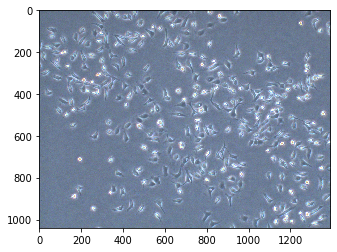

In [54]:
path = './data/HEK293/HEK293 40x (1).jpg'
img = PIL.Image.open(path)
imshow(np.asarray(img))
resp = do_predict(path)
print(f'This image was classified to {resp[0]} with {resp[1][-1]:.2f}')

In [ ]:
# with open('t', 'w') as f:
#     f.write(image_normalized[[-1][-1]])
image_normalized

In [69]:
print(list(model.signatures.keys()))
infer = model.signatures["serving_default"]
print(infer.structured_outputs)

['serving_default']
{'dense': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense')}


In [137]:
import grpc
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc

channel = grpc.insecure_channel('localhost:8500')
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
request = predict_pb2.PredictRequest()
request.model_spec.name = 'cell'
request.model_spec.signature_name = 'serving_default'
request.inputs['keras_layer_1_input'].CopyFrom(tf.make_tensor_proto(image_normalized, shape=[1, 224, 224, 3]))
request_future = stub.Predict.future(request, 10.25)
request_future.result()

outputs {
  key: "dense"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 1
      }
      dim {
        size: 3
      }
    }
    float_val: 0.9837099313735962
    float_val: 0.016159625723958015
    float_val: 0.0001303718308918178
  }
}
model_spec {
  name: "cell"
  version {
    value: 1
  }
  signature_name: "serving_default"
}